In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# База POLY

Обучение простой сети для прогнозирования временного ряда (только close) + визуализация.

Прогнозирование на 10 шагов вперёд прямым способом и визуализируйте результат.

Графики сравнения предсказания с оригинальным сигналом по всем 10 шагам предсказания (10 графиков на разных отдельных осях).

In [ ]:
#Загружаем библиотеки

import pandas as pd #Пандас
import matplotlib.pyplot as plt #Отрисовка графиков
from tensorflow.keras import utils #Для to_categorical
import numpy as np #Numpy
from tensorflow.keras.optimizers import Adam #Оптимизатор
from tensorflow.keras.models import Sequential, Model #Два варианта моделей
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, LSTM #Стандартные слои
from sklearn.preprocessing import StandardScaler, MinMaxScaler #Нормировщики
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # для генерации выборки временных рядов

# Рисовать графики сразу же
%matplotlib inline

In [ ]:
base_POLY_1d1 = pd.read_csv('/content/drive/MyDrive/T_R/POLY_1d_from_MOEX.txt', sep=',')
base_POLY_1d2 = pd.read_csv('/content/drive/MyDrive/T_R/POLY_1d_from_MOEX2.txt', sep=',')
dataPOLY_1d1 = base_POLY_1d1.iloc[:,4:]
dataPOLY_1d2 = base_POLY_1d2.iloc[:,4:]

In [ ]:
dataPOLY_1d1.shape[0]

13575

In [ ]:
dataPOLY_1d1

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,511.0,534.5,510.0,515.0,2071
1,512.0,518.5,510.0,514.5,630
2,512.0,514.5,505.5,505.5,955
3,505.0,512.5,505.0,507.0,100
4,506.0,506.0,501.0,501.0,589
...,...,...,...,...,...
13570,1750.0,1764.9,1750.0,1754.4,22566
13571,1753.6,1755.5,1745.0,1748.5,12672
13572,1748.5,1755.2,1747.6,1752.1,5602
13573,1751.0,1754.9,1748.0,1753.4,3409


In [ ]:
# Объединяем базы из двух файлов
data = base_POLY_1d1.copy()                 # Создаем копию первой базы
data = pd.concat([dataPOLY_1d1,dataPOLY_1d2]) # Присоединяем к ней вторую базу
data = np.array(data)                   # Превращаем в numpy массив

In [ ]:
print(len(data))      # Выводим размер базы

15040


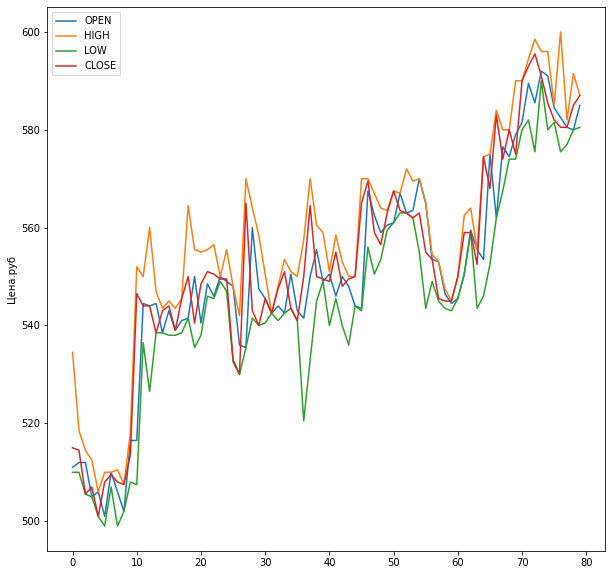

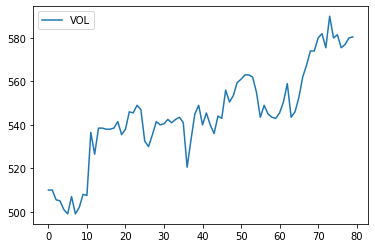

In [ ]:
#Отображаем исходные от точки start и длинной step
start = 0            #С какой точки начинаем
step = 80 #data.shape[0] #Сколько точек отрисуем


#Заполняем текстовые названия каналов данных
chanelNames = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOL']

#Рисуем все графики данных
#Четыре основных канала - open, max, min, close

plt.figure(figsize=(10, 10))
for i in range(4):
  #Отрисовываем часть данных
  #От начальной точки, до начальной точки + размер шага отрисовки
  plt.plot(data[start:start+step,i], 
          label=chanelNames[i])
plt.ylabel('Цена.руб')
plt.legend()
plt.show()

#Канал volume
plt.plot(data[start:start+step,+2], label="VOL")
plt.legend()
plt.show()

In [ ]:
#Формируем параметры загрузки данных
xLen = 150  #Анализируем по 150 прошедшим точкам 
valLen = 3000                 #Используем 3000 записей для проверки
stepsForward = 1                 #шаг предсказания
trainLen = data.shape[0]-valLen #Размер тренировочной выборки
#Делим данные на тренировочную и тестовую выборки 
xTrain, xTest = data[:trainLen-stepsForward,2][..., None],  data[trainLen+xLen+2:-stepsForward,2][..., None]


#Делим данные на тренировочную и тестовую выборки 
xScaler = MinMaxScaler()
xScaler.fit(xTrain.reshape(-1,1))

xTrain = xScaler.transform(xTrain)
yTest = xScaler.transform(xTest)

#Для подготовки yTrain на 10 шагов вперед необходимо создать дополнительный датасет
yTrain = np.array([data[:trainLen, 4][i:i+stepsForward] for i in range(trainLen-stepsForward)])
yTest = np.array([data[trainLen+xLen+2:,4][i:i+stepsForward] for i in range(valLen-xLen-stepsForward-2)])
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

#Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(xTrain, yTrain,  #В качестве параметров наши выборки
                                   length=xLen, sampling_rate=1, #Для каждой точки
                                   batch_size=20) #Размер batch, который будем скармливать модели


testDataGen = TimeseriesGenerator(xTest, yTest, #В качестве параметров наши выборки
                                  length=xLen, sampling_rate=1, #Для каждой точки
                                  batch_size=20) #Размер batch, который будем скармливать модели


In [ ]:
data.shape

(15040, 5)

In [ ]:
yTrain[0]

array([0.00022033])

In [ ]:
xTrain[0]

array([0.09601557])

In [ ]:
print(trainDataGen[0][0].shape,
      trainDataGen[0][1].shape)

(20, 150, 1) (20, 1)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
595/595 [==============================] - 5s 3ms/step - loss: 8.1684e-04 - val_loss: 9074.8301
Epoch 2/20
595/595 [==============================] - 1s 2ms/step - loss: 0.0015 - val_loss: 17280.4121
Epoch 3/20
595/595 [==============================] - 1s 3ms/step - loss: 3.0120e-04 - val_loss: 22659.9551
Epoch 4/20
595/595 [==============================] - 1s 3ms/step - loss: 1.9158e-04 - val_loss: 735.6950
Epoch 5/20
595/595 [==============================] - 2s 3ms/step - loss: 2.9559e-04 - val_loss: 1361.9250
Epoch 6/20
595/595 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 5529.5186
Epoch 7/20
595/595 [==============================] - 1s 3ms/step - loss: 1.3838e-04 - val_loss: 1152.5250
Epoch 8/20
595/595 [==============================] - 1s 2ms/step - loss: 0.0033 - val_loss: 344.3554
Epoch 9/20
595/595 [==============================] - 1s 2ms/step - loss: 1.2827e-04 - val_loss: 2802.3884
Epoch 10/20
595/595 [============================

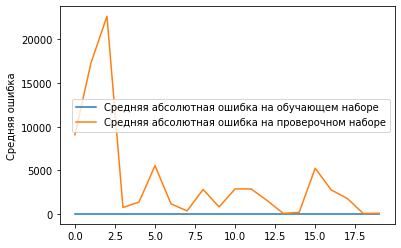

In [ ]:
#Создаём нейронку
modelD = Sequential()
modelD.add(Dense(150,input_shape = (xLen,1), activation="linear" )) # 5 - количество каналов
modelD.add(Flatten())
modelD.add(Dense(yTrain.shape[1], activation="linear"))

#Компилируем
modelD.compile(loss="mse", optimizer=Adam(lr=1e-4))

#Запускаем обучение
history = modelD.fit_generator(
                    trainDataGen, 
                    epochs=20, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

#Выводим графики
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
# Функция рассчитываем результаты прогнозирования сети
# В аргументы принимает сеть (currModel) и проверочную выборку
# Выдаёт результаты предсказания predVal
# И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
def getPred(currModel, xVal, yVal, yScaler):
  # Предсказываем ответ сети по проверочной выборке
  # И возвращаем исходны масштаб данных, до нормализации
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

# Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
# start - точка с которой начинаем отрисовку графика
# step - длина графика, которую отрисовываем
# channel - какой канал отрисовываем
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, 0],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  
# Функция расёта корреляции дух одномерных векторов
def correlate(a, b):
  # Рассчитываем основные показатели
  ma = a.mean() # Среднее значение первого вектора
  mb = b.mean() # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение первого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора
  
  #Рассчитываем корреляцию
  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

# Функция рисуем корреляцию прогнозированного сигнала с правильным
# Смещая на различное количество шагов назад
# Для проверки появления эффекта автокорреляции
# channels - по каким каналам отображать корреляцию
# corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  # Проходим по всем каналам
  for ch in channels:
    corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
    yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, 0]))

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смещении на i шагов обратно

      # Постепенно увеличиваем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Отображаем график коррелций для данного шага
    plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
    plt.plot(own_corr, label='Эталон')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

In [ ]:
#Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, sampling_rate=1,
                               batch_size=len(xTest)) #размер batch будет равен длине нашей выборки
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

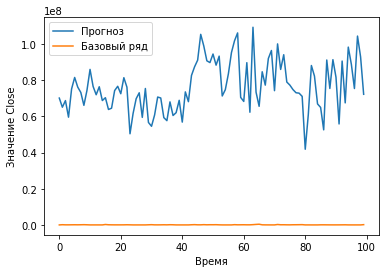

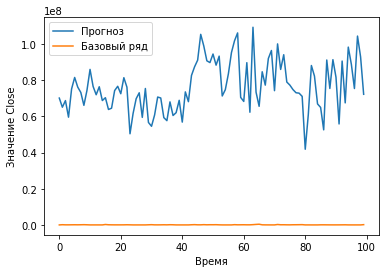

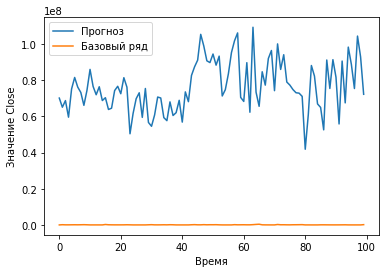

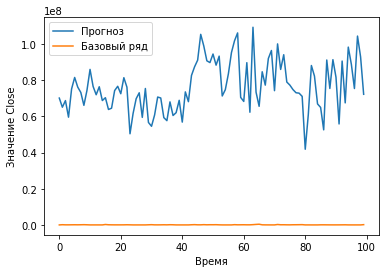

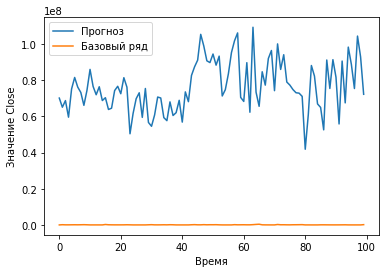

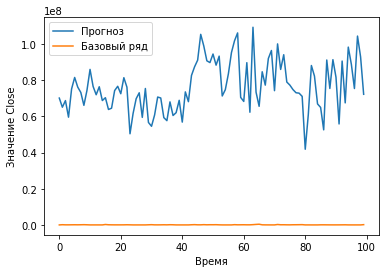

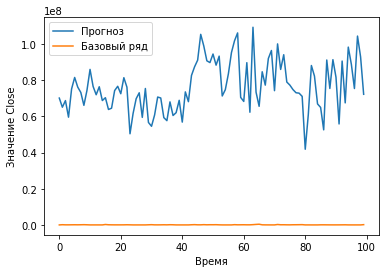

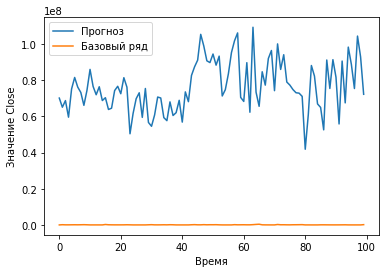

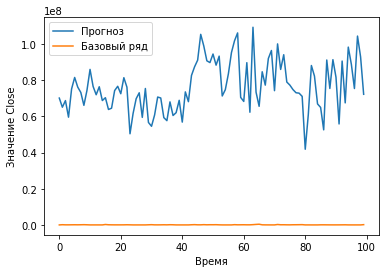

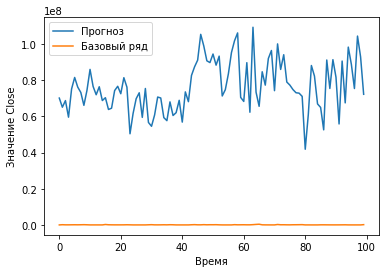

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelD #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler) #Прогнозируем данные

#Отображаем графики
for i in range(10):
    showPredict(0, 100, 0, predVal, yValUnscaled)


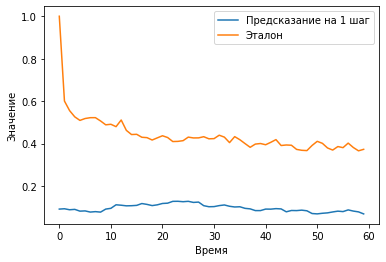

In [ ]:
#Отображаем корреляцию
#Используем выходной канал - только close
#Проверяем корреляцию на глубину 60 шагов
showCorr([0], 60, predVal, yValUnscaled)

**ОДНОМЕРНАЯ СВЁРТКА**

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
595/595 [==============================] - 32s 4ms/step - loss: 0.0707 - val_loss: 19615.0078
Epoch 2/20
595/595 [==============================] - 2s 3ms/step - loss: 3.1929e-04 - val_loss: 1361.0812
Epoch 3/20
595/595 [==============================] - 2s 3ms/step - loss: 2.2678e-04 - val_loss: 2235.8093
Epoch 4/20
595/595 [==============================] - 2s 3ms/step - loss: 1.9965e-04 - val_loss: 776.7935
Epoch 5/20
595/595 [==============================] - 2s 3ms/step - loss: 1.9112e-04 - val_loss: 1166.2433
Epoch 6/20
595/595 [==============================] - 2s 3ms/step - loss: 9.8353e-05 - val_loss: 4427.0933
Epoch 7/20
595/595 [==============================] - 2s 3ms/step - loss: 2.8741e-04 - val_loss: 10367.8076
Epoch 8/20
595/595 [==============================] - 2s 3ms/step - loss: 0.0117 - val_loss: 77658.8516
Epoch 9/20
595/595 [==============================] - 2s 3ms/step - loss: 2.6531e-04 - val_loss: 4559.6094
Epoch 10/20
595/595 [=====================

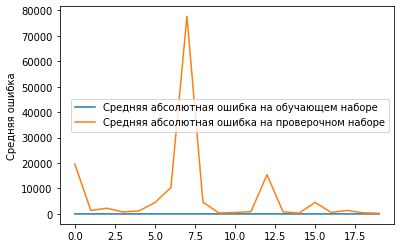

In [ ]:
modelC = Sequential()

modelC.add(Conv1D(200, 4, input_shape = (trainDataGen[0][0].shape[1:]), activation="linear"))
modelC.add(Flatten())
modelC.add(Dense(100, activation="linear"))
modelC.add(Dense(yTrain.shape[1], activation="linear"))

modelC.compile(loss="mse", optimizer=Adam(lr=1e-4))

history = modelC.fit_generator(trainDataGen,
                    epochs=20, 
                    verbose=1,
                    validation_data=testDataGen)
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
trainDataGen[0][0].shape[1:]

(30, 50)

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelC
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

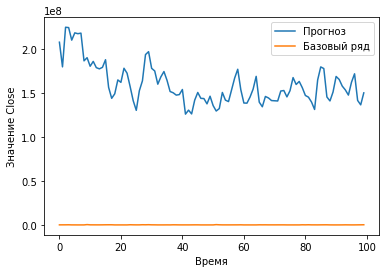

In [ ]:
#Отображаем графики
showPredict(1000, 100, 0, predVal, yValUnscaled)

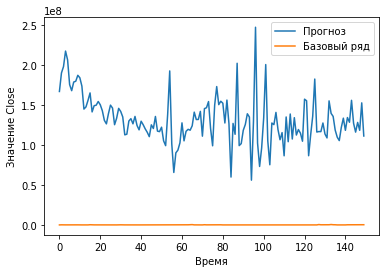

In [ ]:
for i in range(1):
    showPredict(0, 150, i, predVal, yValUnscaled)

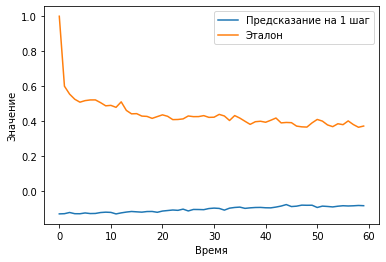

In [ ]:
#Отображаем корреляцию
showCorr([0], 60, predVal, yValUnscaled)

**Сеть с предсказанием на один шаг и valLen = 900 из LSTM, Conv1D и/или Dense слоёв так, чтобы корреляция на старте была 99,9% и строго убывала.**


In [ ]:
#Формируем параметры загрузки данных
xLen = 90                    #Анализируем по 90 прошедшим точкам 
valLen = 900              #Используем 900 записей для проверки

trainLen = data.shape[0]-valLen  # Размер тренировочной выборки

#Делим данные на тренировочную и тестовую выборки 
xTrain, xTest = data[:trainLen], data[trainLen+xLen+2:]

#Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

#Делаем reshape,т.к. у нас только один столбец по одному значению
yTrain,yTest = np.reshape(data[:trainLen, 3],(-1,1)), np.reshape(data[trainLen+xLen+2:, 3], (-1, 1))
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

#Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(xTrain, yTrain, #В качестве параметров наши выборки
                                   length=xLen, sampling_rate=1,  #Для каждой точки (из промежутка длины xLen)  stride=1,
                                   batch_size=20)  #Размер batch, который будем скармливать модели

#Создаем аналогичный генератор для валидации при обучении
testDataGen = TimeseriesGenerator(xTest, yTest, #В качестве параметров наши выборки
                                  length=xLen, sampling_rate=1, #Для каждой точки (из промежутка длины xLen)  stride=1,
                                  batch_size=20)  #Размер batch, который будем скармливать модели


In [ ]:
print(trainDataGen[0][0].shape,
      trainDataGen[0][1].shape)

(20, 90, 5) (20, 1)


In [ ]:
# Функция рассчитываем результаты прогнозирования сети
# В аргументы принимает сеть (currModel) и проверочную выборку
# Выдаёт результаты предсказания predVal
# И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
def getPred(currModel, xVal, yVal, yScaler):
  # Предсказываем ответ сети по проверочной выборке
  # И возвращаем исходны масштаб данных, до нормализации
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

# Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
# start - точка с которой начинаем отрисовку графика
# step - длина графика, которую отрисовываем
# channel - какой канал отрисовываем
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, 0],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  
# Функция расёта корреляции дух одномерных векторов
def correlate(a, b):
  # Рассчитываем основные показатели
  ma = a.mean() # Среднее значение первого вектора
  mb = b.mean() # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение первого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора
  
  #Рассчитываем корреляцию
  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

# Функция рисуем корреляцию прогнозированного сигнала с правильным
# Смещая на различное количество шагов назад
# Для проверки появления эффекта автокорреляции
# channels - по каким каналам отображать корреляцию
# corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  # Проходим по всем каналам
  for ch in channels:
    corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
    yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, 0]))

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смещении на i шагов обратно

      # Постепенно увеличиваем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Отображаем график коррелций для данного шага
    plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
    plt.plot(own_corr, label='Эталон')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

In [ ]:
#Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, sampling_rate=1,
                               batch_size=len(xTest)) #размер batch будет равен длине нашей выборки
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

In [ ]:
yVal[0].shape

(718, 1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
703/703 [==============================] - 3s 4ms/step - loss: 0.4209 - val_loss: 0.0024
Epoch 2/20
703/703 [==============================] - 3s 4ms/step - loss: 0.0061 - val_loss: 0.0017
Epoch 3/20
703/703 [==============================] - 3s 4ms/step - loss: 0.0831 - val_loss: 0.0138
Epoch 4/20
703/703 [==============================] - 3s 4ms/step - loss: 0.0022 - val_loss: 0.0059
Epoch 5/20
703/703 [==============================] - 3s 4ms/step - loss: 4.1400e-04 - val_loss: 0.0012
Epoch 6/20
703/703 [==============================] - 3s 4ms/step - loss: 0.0018 - val_loss: 0.0027
Epoch 7/20
703/703 [==============================] - 3s 4ms/step - loss: 3.1034e-04 - val_loss: 5.1802e-04
Epoch 8/20
703/703 [==============================] - 3s 4ms/step - loss: 6.7135e-04 - val_loss: 0.0024
Epoch 9/20
703/703 [==============================] - 3s 4ms/step - loss: 0.0420 - val_loss: 0.0095
Epoch 10/20
703/703 [==============================] - 3s 4ms/step - loss: 0.0029 - 

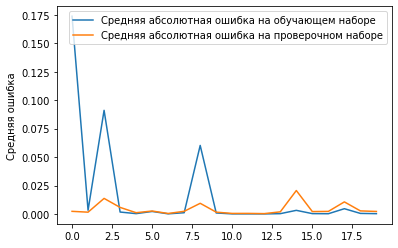

In [ ]:
modelC = Sequential()

modelC.add(Conv1D(300, 5, input_shape = (xLen,5), activation="linear"))
modelC.add(Flatten())

modelC.add(Dense(300, activation="linear"))
modelC.add(Dense(1, activation="linear"))

modelC.compile(loss="mse", optimizer=Adam(lr=1e-4))

history = modelC.fit_generator(trainDataGen,
                    epochs=20, 
                    verbose=1,
                    validation_data=testDataGen)

plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

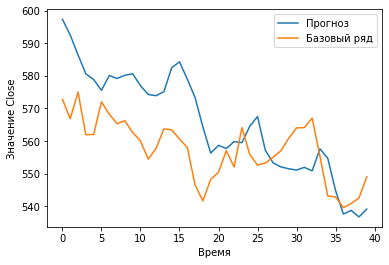

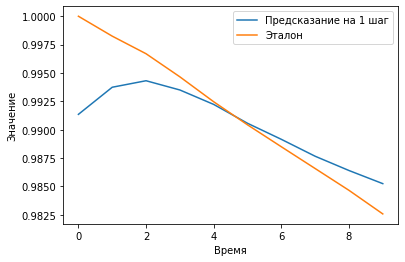

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelC
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

#Отображаем графики
showPredict(100, 40, 0, predVal, yValUnscaled)

#Отображаем корреляцию
showCorr([0], 10, predVal, yValUnscaled)

**Несколько усовершенствований в предсказании временного ряда.
Добавляем к исходному сигналу расширенные данные:**

* попарные разности каналов
* модули попарных разностей каналов
* попарные произведения каналов
* обратное значение каналов x_new = 1/(x + 1e-3)
* первые производные каналов (x[n] - x[n-1])
* вторые производные каналов (x[n] - 2*x[n-1] + x[n-2])

Просмотр сети в прошлое, при формировании входного сигнала используем

* 100 точек с шагом назад по 1,

* 100 точек с шагом назад по 10 (или сами точки, или среднее по отрезку в 10 точек).


In [ ]:
#Загружаем библиотеки

import pandas as pd #Пандас
import matplotlib.pyplot as plt #Отрисовка графиков
from tensorflow.keras import utils #Для to_categorical
import numpy as np #Numpy
from tensorflow.keras.optimizers import Adam #Оптимизатор
from tensorflow.keras.models import Sequential, Model #Два варианты моделей
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, LSTM #Стандартные слои
from sklearn.preprocessing import StandardScaler, MinMaxScaler #Нормировщики
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # для генерации выборки временных рядов

# Рисовать графики сразу же
%matplotlib inline

In [ ]:
base_POLY_1d1 = pd.read_csv('/content/drive/MyDrive/T_R/POLY_1d_from_MOEX.txt', sep=',')
base_POLY_1d2 = pd.read_csv('/content/drive/MyDrive/T_R/POLY_1d_from_MOEX2.txt', sep=',')
dataPOLY_1d1 = base_POLY_1d1.iloc[:,4:]
dataPOLY_1d2 = base_POLY_1d2.iloc[:,4:]
data = pd.concat([dataPOLY_1d1,dataPOLY_1d2]) # Объединяем
data = data.reset_index(drop = True) #Обнуляем индесы
data #Выводим таблицу

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,511.0,534.5,510.0,515.0,2071
1,512.0,518.5,510.0,514.5,630
2,512.0,514.5,505.5,505.5,955
3,505.0,512.5,505.0,507.0,100
4,506.0,506.0,501.0,501.0,589
...,...,...,...,...,...
15035,1758.0,1782.5,1745.5,1770.3,863953
15036,1770.0,1783.8,1530.0,1696.8,1519259
15037,1714.7,1730.0,1676.0,1694.2,1034671
15038,1694.2,1701.8,1639.0,1672.3,956552


In [ ]:
col = data.columns #Получаем названия столбцов
print(col) #Выводим

Index(['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<VOL>'], dtype='object')


In [ ]:
#Задаем циклы для столбцов таким образом, чтобы происходил перебор всех возможных пар:
#Проходим по индексам массива с именами столбцов 'OPEN', 'MAX', 'MIN', 'CLOSE', 'VOLUME', 
#получая пары 'OPEN' и 'HIGH', 'OPEN' и 'LOW', 'OPEN' и 'CLOSE' ..., 'MAX' и 'MIN', 'MAX' и 'CLOSE' и т.д
for i in range(col.shape[0]):                                                   #Для всех пар
  for j in range(i + 1 , col.shape[0]):                                         #Считаем
    data[col[i] + '-' + col[j]] = data[col[i]] - data[col[j]]                   #Разности
    data['|' + col[i] + '-' + col[j] + '|'] = abs(data[col[i]] - data[col[j]])  #Модули разностей
    data[col[i] + '*' + col[j]] = data[col[i]] * data[col[j]]                   #Произведения

#Для каждого столбца 'OPEN', 'MAX', 'MIN', 'CLOSE', 'VOLUME' считаем:
for i in col:
  data['Обратный ' + i] = 1 / (data[i] + 1e-3) #обратные значения. 1e-3 в формуле нужно, чтобы случайно не разделить на 0
  data['Производная от ' + i] = np.nan #Создаем пустой столбец 
  data['Производная от ' + i][1:] = data[i][1:].reset_index(drop=True) - data[i][:-1].reset_index(drop=True) #При помощи срезов считаем первые производные .reset_index(drop=True) нужен для корректных подсчетов
  data['Вторая производная от ' + i] = np.nan #Создаем пустой столбец 
  data['Вторая производная от ' + i][2:] = data[i][2:].reset_index(drop=True) - 2 * data[i][1:-1].reset_index(drop=True) + data[i][:-2].reset_index(drop=True) #При помощи срезов считаем вторые производные 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [ ]:
data #Смотрим что получилось

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,<OPEN>-<HIGH>,|<OPEN>-<HIGH>|,<OPEN>*<HIGH>,<OPEN>-<LOW>,|<OPEN>-<LOW>|,<OPEN>*<LOW>,<OPEN>-<CLOSE>,|<OPEN>-<CLOSE>|,<OPEN>*<CLOSE>,<OPEN>-<VOL>,|<OPEN>-<VOL>|,<OPEN>*<VOL>,<HIGH>-<LOW>,|<HIGH>-<LOW>|,<HIGH>*<LOW>,<HIGH>-<CLOSE>,|<HIGH>-<CLOSE>|,<HIGH>*<CLOSE>,<HIGH>-<VOL>,|<HIGH>-<VOL>|,<HIGH>*<VOL>,<LOW>-<CLOSE>,|<LOW>-<CLOSE>|,<LOW>*<CLOSE>,<LOW>-<VOL>,|<LOW>-<VOL>|,<LOW>*<VOL>,<CLOSE>-<VOL>,|<CLOSE>-<VOL>|,<CLOSE>*<VOL>,Обратный <OPEN>,Производная от <OPEN>,Вторая производная от <OPEN>,Обратный <HIGH>,Производная от <HIGH>,Вторая производная от <HIGH>,Обратный <LOW>,Производная от <LOW>,Вторая производная от <LOW>,Обратный <CLOSE>,Производная от <CLOSE>,Вторая производная от <CLOSE>,Обратный <VOL>,Производная от <VOL>,Вторая производная от <VOL>
0,511.0,534.5,510.0,515.0,2071,-23.5,23.5,273129.50,1.0,1.0,260610.0,-4.0,4.0,263165.00,-1560.0,1560.0,1.058281e+06,24.5,24.5,272595.00,19.5,19.5,275267.50,-1536.5,1536.5,1.106950e+06,-5.0,5.0,262650.00,-1561.0,1561.0,1.056210e+06,-1556.0,1556.0,1.066565e+06,0.001957,NaN,NaN,0.001871,NaN,NaN,0.001961,NaN,NaN,0.001942,NaN,NaN,4.828583e-04,NaN,NaN
1,512.0,518.5,510.0,514.5,630,-6.5,6.5,265472.00,2.0,2.0,261120.0,-2.5,2.5,263424.00,-118.0,118.0,3.225600e+05,8.5,8.5,264435.00,4.0,4.0,266768.25,-111.5,111.5,3.266550e+05,-4.5,4.5,262395.00,-120.0,120.0,3.213000e+05,-115.5,115.5,3.241350e+05,0.001953,1.0,NaN,0.001929,-16.0,NaN,0.001961,0.0,NaN,0.001944,-0.5,NaN,1.587299e-03,-1441.0,NaN
2,512.0,514.5,505.5,505.5,955,-2.5,2.5,263424.00,6.5,6.5,258816.0,6.5,6.5,258816.00,-443.0,443.0,4.889600e+05,9.0,9.0,260079.75,9.0,9.0,260079.75,-440.5,440.5,4.913475e+05,0.0,0.0,255530.25,-449.5,449.5,4.827525e+05,-449.5,449.5,4.827525e+05,0.001953,0.0,-1.0,0.001944,-4.0,12.0,0.001978,-4.5,-4.5,0.001978,-9.0,-8.5,1.047119e-03,325.0,1766.0
3,505.0,512.5,505.0,507.0,100,-7.5,7.5,258812.50,0.0,0.0,255025.0,-2.0,2.0,256035.00,405.0,405.0,5.050000e+04,7.5,7.5,258812.50,5.5,5.5,259837.50,412.5,412.5,5.125000e+04,-2.0,2.0,256035.00,405.0,405.0,5.050000e+04,407.0,407.0,5.070000e+04,0.001980,-7.0,-7.0,0.001951,-2.0,2.0,0.001980,-0.5,4.0,0.001972,1.5,10.5,9.999900e-03,-855.0,-1180.0
4,506.0,506.0,501.0,501.0,589,0.0,0.0,256036.00,5.0,5.0,253506.0,5.0,5.0,253506.00,-83.0,83.0,2.980340e+05,5.0,5.0,253506.00,5.0,5.0,253506.00,-83.0,83.0,2.980340e+05,0.0,0.0,251001.00,-88.0,88.0,2.950890e+05,-88.0,88.0,2.950890e+05,0.001976,1.0,8.0,0.001976,-6.5,-4.5,0.001996,-4.0,-3.5,0.001996,-6.0,-7.5,1.697790e-03,489.0,1344.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15035,1758.0,1782.5,1745.5,1770.3,863953,-24.5,24.5,3133635.00,12.5,12.5,3068589.0,-12.3,12.3,3112187.40,-862195.0,862195.0,1.518829e+09,37.0,37.0,3111353.75,12.2,12.2,3155559.75,-862170.5,862170.5,1.539996e+09,-24.8,24.8,3090058.65,-862207.5,862207.5,1.508030e+09,-862182.7,862182.7,1.529456e+09,0.000569,-4.9,20.8,0.000561,6.5,28.7,0.000573,4.0,5.7,0.000565,20.2,38.9,1.157470e-06,319481.0,498995.0
15036,1770.0,1783.8,1530.0,1696.8,1519259,-13.8,13.8,3157326.00,240.0,240.0,2708100.0,73.2,73.2,3003336.00,-1517489.0,1517489.0,2.689088e+09,253.8,253.8,2729214.00,87.0,87.0,3026751.84,-1517475.2,1517475.2,2.710054e+09,-166.8,166.8,2596104.00,-1517729.0,1517729.0,2.324466e+09,-1517562.2,1517562.2,2.577879e+09,0.000565,12.0,16.9,0.000561,1.3,-5.2,0.000654,-215.5,-219.5,0.000589,-73.5,-93.7,6.582156e-07,655306.0,335825.0
15037,1714.7,1730.0,1676.0,1694.2,1034671,-15.3,15.3,2966431.00,38.7,38.7,2873837.2,20.5,20.5,2905044.74,-1032956.3,1032956.3,1.774150e+09,54.0,54.0,2899480.00,35.8,35.8,2930966.00,-1032941.0,1032941.0,1.789981e+09,-18.2,18.2,2839479.20,-1032995.0,1032995.0,1.734109e+09,-1032976.8,1032976.8,1.752940e+09,0.000583,-55.3,-67.3,0.000578,-53.8,-55.1,0.000597,146.0,361.5,0.000590,-2.6,70.9,9.664908e-07,-484588.0,-1139894.0
15038,1694.2,1701.8,1639.0,1672.3,956552,-7.6,7.6,2

In [ ]:
data = np.array(data.iloc[2:]) #Берем все столбцы с первых двух
data = np.array(data) #Переводим в numpy
columnsamount = data.shape[1] #При помощи этой переменной будем использовать одну и ту же архитетуру под разные матрицы

**Функция загрузки данных**

In [ ]:
#Формируем параметры загрузки данных

xLen = 30  #Анализируем по 30 прошедшим точкам 
valLen = 3000   #Используем 3000 записей для проверки

trainLen = data.shape[0]-valLen # Размер тренировочной выборки

#Делим данные на тренировочную и тестовую выборки 
xTrain,xTest = data[:trainLen], data[trainLen+xLen+2:]

#Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

#Делаем reshape,т.к. у нас только один столбец по одному значению
yTrain,yTest = np.reshape(data[:trainLen,3],(-1,1)), np.reshape(data[trainLen+xLen+2:,3],(-1,1)) 
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

#Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(xTrain, yTrain,           #В качестве параметров наши выборки
                               length=xLen, stride=1, #Для каждой точки (из промежутка длины xLen)
                               batch_size=20)                #Размер batch, который будем скармливать модели

#Создаем аналогичный генератор для валидации при обучении
testDataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, stride=1,
                               batch_size=20)

In [ ]:
xTrain[0]

array([8.99721213e-02, 8.87449529e-02, 9.22087810e-02, 8.56395545e-02,
       1.01542293e-04, 9.82650937e-01, 1.73490632e-02, 4.07389719e-02,
       4.88721805e-02, 4.88721805e-02, 4.12197304e-02, 6.12257661e-01,
       7.11159737e-02, 3.97288871e-02, 9.99848490e-01, 4.71023311e-05,
       7.86617249e-05, 5.45454545e-02, 5.45454545e-02, 4.14188840e-02,
       6.61764706e-02, 6.61764706e-02, 3.98786118e-02, 9.99848756e-01,
       4.68362836e-05, 7.74640799e-05, 1.00000000e+00, 0.00000000e+00,
       4.05975006e-02, 9.99848011e-01, 4.77942298e-05, 7.76621534e-05,
       9.99848011e-01, 4.78474823e-05, 7.69289426e-05, 7.20735340e-01,
       4.26944972e-01, 5.24197196e-01, 7.24399419e-01, 5.25302284e-01,
       7.09162146e-01, 7.12046319e-01, 5.03906250e-01, 3.13570487e-01,
       7.30765190e-01, 3.91304348e-01, 4.91314031e-01, 1.04806001e-03,
       5.06510555e-01, 6.58885608e-01])

In [ ]:
print(trainDataGen[0][0].shape,
      trainDataGen[0][1].shape)

(20, 30, 50) (20, 1)


## Визуализация результатов

In [ ]:
# Функция рассчитываем результаты прогнозирования сети
# В аргументы принимает сеть (currModel) и проверочную выборку
# Выдаёт результаты предсказания predVal
# И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
def getPred(currModel, xVal, yVal, yScaler):
  # Предсказываем ответ сети по проверочной выборке
  # И возвращаем исходны масштаб данных, до нормализации
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

# Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
# start - точка с которой начинаем отрисовку графика
# step - длина графика, которую отрисовываем
# channel - какой канал отрисовываем
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, 0],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  
# Функция расёта корреляции дух одномерных векторов
def correlate(a, b):
  # Рассчитываем основные показатели
  ma = a.mean() # Среднее значение первого вектора
  mb = b.mean() # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение первого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора
  
  #Рассчитываем корреляцию
  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

# Функция рисуем корреляцию прогнозированного сигнала с правильным
# Смещая на различное количество шагов назад
# Для проверки появления эффекта автокорреляции
# channels - по каким каналам отображать корреляцию
# corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  # Проходим по всем каналам
  for ch in channels:
    corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
    yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, 0]))

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смещении на i шагов обратно

      # Постепенно увеличиваем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Отображаем график коррелций для данного шага
    plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
    plt.plot(own_corr, label='Эталон')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

In [ ]:
#Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, sampling_rate=1,
                               batch_size=len(xTest)) #размер batch будет равен длине нашей выборки
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

## Полносвязная сеть

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
601/601 [==============================] - 2s 3ms/step - loss: 0.0034 - val_loss: 0.0077
Epoch 2/20
601/601 [==============================] - 2s 3ms/step - loss: 0.0011 - val_loss: 0.0092
Epoch 3/20
601/601 [==============================] - 2s 3ms/step - loss: 5.3318e-04 - val_loss: 0.0065
Epoch 4/20
601/601 [==============================] - 2s 3ms/step - loss: 0.0023 - val_loss: 0.0046
Epoch 5/20
601/601 [==============================] - 2s 3ms/step - loss: 3.0036e-04 - val_loss: 0.0040
Epoch 6/20
601/601 [==============================] - 2s 3ms/step - loss: 3.2549e-04 - val_loss: 0.0052
Epoch 7/20
601/601 [==============================] - 2s 3ms/step - loss: 0.0010 - val_loss: 0.0113
Epoch 8/20
601/601 [==============================] - 2s 3ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 9/20
601/601 [==============================] - 2s 3ms/step - loss: 1.2344e-04 - val_loss: 0.0027
Epoch 10/20
601/601 [==============================] - 2s 3ms/step - loss: 6.4830e-0

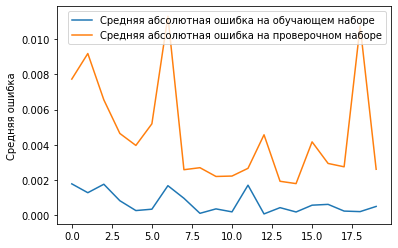

In [ ]:
#Создаём нейронку
modelD = Sequential()
modelD.add(Dense(150,input_shape = (xLen,columnsamount), activation="linear" )) 
modelD.add(Flatten())
modelD.add(Dense(1, activation="linear"))

#Компилируем
modelD.compile(loss="mse", optimizer=Adam(lr=1e-4))

#Запускаем обучение
history = modelD.fit_generator(
                    trainDataGen, 
                    epochs=20, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

#Выводим графики
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

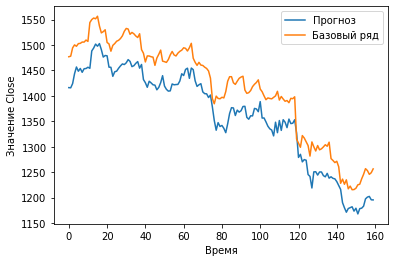

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelD #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler) #Прогнозируем данные

#Отображаем графики
showPredict(0, 160, 0, predVal, yValUnscaled)


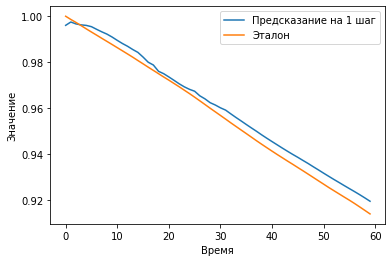

In [ ]:
#Отображаем корреляцию
#Используем выходной канал - только open
#Проверяем корреляцию на глубину 60 шагов
showCorr([0], 60, predVal, yValUnscaled)

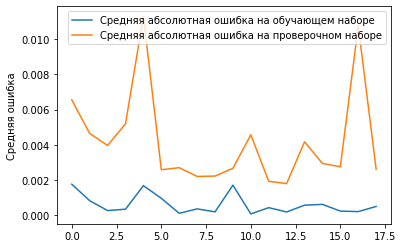

In [ ]:
#Выводим графики
plt.plot(history.history['loss'][2:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'][2:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

## Одномерная свёртка

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
601/601 [==============================] - 2s 3ms/step - loss: 0.0771 - val_loss: 0.0215
Epoch 2/20
601/601 [==============================] - 2s 3ms/step - loss: 0.0236 - val_loss: 0.0101
Epoch 3/20
601/601 [==============================] - 2s 3ms/step - loss: 3.1186e-04 - val_loss: 0.0051
Epoch 4/20
601/601 [==============================] - 2s 3ms/step - loss: 0.0071 - val_loss: 0.0044
Epoch 5/20
601/601 [==============================] - 2s 3ms/step - loss: 7.5254e-04 - val_loss: 0.0095
Epoch 6/20
601/601 [==============================] - 2s 3ms/step - loss: 9.7554e-04 - val_loss: 0.1006
Epoch 7/20
601/601 [==============================] - 2s 3ms/step - loss: 0.0025 - val_loss: 0.0109
Epoch 8/20
601/601 [==============================] - 2s 3ms/step - loss: 9.8614e-04 - val_loss: 0.0050
Epoch 9/20
601/601 [==============================] - 2s 3ms/step - loss: 6.9033e-04 - val_loss: 0.0058
Epoch 10/20
601/601 [==============================] - 2s 3ms/step - loss: 0.001

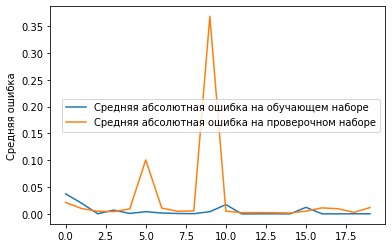

In [ ]:
modelC = Sequential()

modelC.add(Conv1D(200, 5, input_shape = (xLen, columnsamount), activation="linear"))
modelC.add(Flatten())
modelC.add(Dense(100, activation="linear"))
modelC.add(Dense(1, activation="linear"))

modelC.compile(loss="mse", optimizer=Adam(lr=1e-4))

history = modelC.fit_generator(trainDataGen,
                    epochs=20, 
                    verbose=1,
                    validation_data=testDataGen)

plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()



In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelC
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

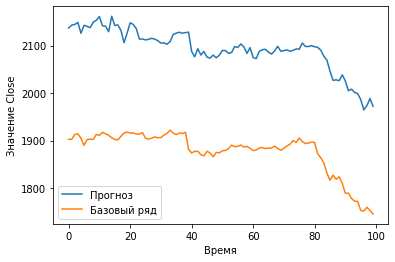

In [ ]:
#Отображаем графики
showPredict(1000, 100, 0, predVal, yValUnscaled)

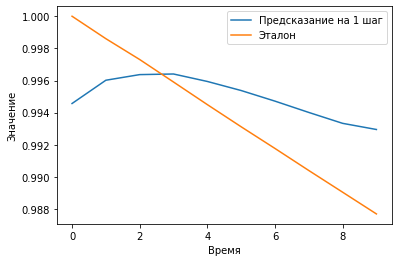

In [ ]:
#Отображаем корреляцию
showCorr([0], 10, predVal, yValUnscaled)

## Увеличенный "просмотр сети в прошлое" без наращивания данных

In [ ]:
base_POLY_1d1 = pd.read_csv('/content/drive/MyDrive/T_R/POLY_1d_from_MOEX.txt', sep=',')
base_POLY_1d2 = pd.read_csv('/content/drive/MyDrive/T_R/POLY_1d_from_MOEX2.txt', sep=',')
dataPOLY_1d1 = base_POLY_1d1.iloc[:,4:]
dataPOLY_1d2 = base_POLY_1d2.iloc[:,4:]
data = pd.concat([dataPOLY_1d1,dataPOLY_1d2]) # Объединяем
data = data.reset_index(drop = True) #Обнуляем индесы
data #Выводим таблицу

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,511.0,534.5,510.0,515.0,2071
1,512.0,518.5,510.0,514.5,630
2,512.0,514.5,505.5,505.5,955
3,505.0,512.5,505.0,507.0,100
4,506.0,506.0,501.0,501.0,589
...,...,...,...,...,...
15035,1758.0,1782.5,1745.5,1770.3,863953
15036,1770.0,1783.8,1530.0,1696.8,1519259
15037,1714.7,1730.0,1676.0,1694.2,1034671
15038,1694.2,1701.8,1639.0,1672.3,956552


In [ ]:
data = np.array(data) #Переводим в numpy
columnsamount = data.shape[1] #При помощи этой переменной будем использовать одну и ту же архитетуру под разные матрицы

In [ ]:
#Собственная функция для формирования обучающей и тестовой выборки для временных рядов 
#numofpoints - число точек, выбираемых с определенным шагом
#stepamongpoints - шаг, с которым выбираются точки 
#continuouslinelen - длина выборки, выбираемая "как есть"
#stride - шаг, с которым предсказываем

def ourTimeseriesGenerator(xTrain, yTrain, numofpoints = 100, stepamongpoints = 10, continuouslinelen = 100, stride = 1):
  x, y, = [], [] #Создаем списки для x и для y

  index = 0 #Начальный индекс задаем равный нулю 

  #считаем длину вектора, который мы захватим при раскусывании на numofpoints точек с шагом stepamongpoints
  periodlinelen = stepamongpoints * (numofpoints - 1) + 1 

  #считаем длину вектора, который мы захватим при раскусывании на numofpoints точек с шагом stepamongpoints и на участок с непрерывной линией
  line = periodlinelen + continuouslinelen

  while index + line + stride < xTrain.shape[0]: # Определеям, позволяет ли длина выборки раскусить данные 

    endperiodline = index + periodlinelen #Вычисляем индекс, где закончится раскусывание с шагом
    periodline = xTrain[index:endperiodline:stepamongpoints] #Раскусываем с шагом
    continuousline = xTrain[endperiodline: endperiodline + continuouslinelen] #Берем непрерывную линию

    x.append(np.concatenate([periodline, continuousline])) #Объединяем две линии и добавляем в x
    y.append(yTrain[endperiodline + continuouslinelen - 1 + stride]) #Элемент, следующий после выборки x через шаг stride отправляем в y
    index += 1 #Увеличиваем индекс на 1

  x = np.array(x) #Преобразуем в numpy
  y = np.array(y) #Преобразуем в numpy
  
  return x, y #Возвращаем x и y

In [ ]:
##Формируем параметры загрузки данных

valLen = 3000 #Используем 3000 записей для проверки
numofpoints = 100
stepamongpoints = 10
continuouslinelen = 100

trainLen = data.shape[0] - valLen # Размер тренировочной выборки

#Делим данные на тренировочную и тестовую выборки 
xTrain, xTest = data[:trainLen], data[trainLen + stepamongpoints * (numofpoints - 1) + 2:]

#Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

#Делаем reshape,т.к. у нас только один столбец по одному значению
yTrain,yTest = np.reshape(data[:trainLen,3],(-1,1)), np.reshape(data[trainLen + stepamongpoints * (numofpoints - 1) + 2:,3],(-1,1)) 
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

xTrainFinal, yTrainFinal = ourTimeseriesGenerator(xTrain, yTrain)
xTestFinal, yTestFinal = ourTimeseriesGenerator(xTest, yTest)

In [ ]:
print(xTrainFinal.shape)
print(yTrainFinal.shape)
print(xTestFinal.shape)
print(yTestFinal.shape)

(10948, 200, 5)
(10948, 1)
(916, 200, 5)
(916, 1)


Epoch 1/20
343/343 [==============================] - 1s 3ms/step - loss: 0.0043 - val_loss: 0.0051
Epoch 2/20
343/343 [==============================] - 1s 2ms/step - loss: 2.6374e-04 - val_loss: 0.0031
Epoch 3/20
343/343 [==============================] - 1s 2ms/step - loss: 1.7857e-04 - val_loss: 0.0030
Epoch 4/20
343/343 [==============================] - 1s 2ms/step - loss: 1.7144e-04 - val_loss: 0.0023
Epoch 5/20
343/343 [==============================] - 1s 2ms/step - loss: 1.3388e-04 - val_loss: 0.0017
Epoch 6/20
343/343 [==============================] - 1s 2ms/step - loss: 1.2668e-04 - val_loss: 0.0014
Epoch 7/20
343/343 [==============================] - 1s 2ms/step - loss: 1.2631e-04 - val_loss: 0.0013
Epoch 8/20
343/343 [==============================] - 1s 2ms/step - loss: 1.3885e-04 - val_loss: 0.0059
Epoch 9/20
343/343 [==============================] - 1s 2ms/step - loss: 3.0769e-04 - val_loss: 0.0012
Epoch 10/20
343/343 [==============================] - 1s 2ms/step -

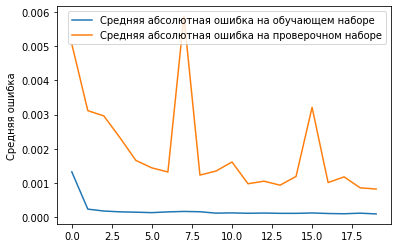

In [ ]:
#Создаём нейронку
modelD = Sequential()
modelD.add(Dense(150,input_shape = (200, columnsamount), activation="linear" )) 
modelD.add(Flatten())
modelD.add(Dense(1, activation="linear"))

#Компилируем
modelD.compile(loss="mse", optimizer=Adam(lr=1e-4))

#Запускаем обучение
history = modelD.fit(xTrainFinal,
                     yTrainFinal, 
                    epochs=20, 
                    verbose=1, 
                    validation_data = (xTestFinal, yTestFinal) 
                    )

#Выводим графики
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

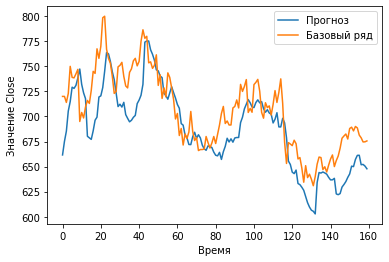

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelD #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xTestFinal, yTestFinal, yScaler) #Прогнозируем данные

#Отображаем графики
showPredict(0, 160, 0, predVal, yValUnscaled)


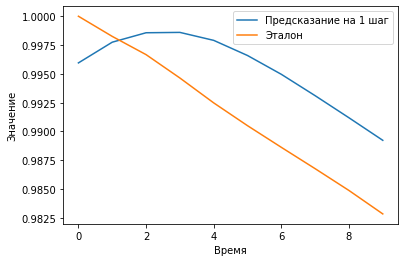

In [ ]:
#Отображаем корреляцию
showCorr([0], 10, predVal, yValUnscaled)